In [44]:
from my_GKFL0 import *
import pandas as pd
import time

In [45]:
data_path = './pfr/'

In [46]:
snrs = ["No noise",20000,15000,10000,7500,5000,3000,2000,1000,800,500,300,200,100,90,80,70,60,50,40,30,20,10,8,6,5,4,3,2,1,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.25,0.2,0.1]
len(snrs)

41

In [47]:
X = 200
T = 200
c1, x, t = load_data(data_path + 'A_200_n.csv', X, T)
c2, x, t = load_data(data_path + 'B_200_n.csv', X, T)
c3, x, t = load_data(data_path + 'C_200_n.csv', X, T)

In [48]:
start = time.time()
c1, c1t, c1x, c1xx, c1xxx = derivatives(c1, x, t)
c2, c2t, c2x, c2xx, c2xxx = derivatives(c2, x, t)
c3, c3t, c3x, c3xx, c3xxx = derivatives(c3, x, t)
print(c1.shape, c1t.shape, c1x.shape, c1xx.shape, c1xxx.shape)
print(time.time() - start)

(192, 192) (36864, 1) (36864, 1) (36864, 1) (36864, 1)
83.71554183959961


In [49]:
c1r = np.reshape(c1, (c1.shape[0] * c1.shape[1], 1), order='F')
c2r = np.reshape(c2, (c2.shape[0] * c2.shape[1], 1), order='F')
c3r = np.reshape(c3, (c3.shape[0] * c3.shape[1], 1), order='F')

# Does Linear Regression recover the PDEs? Yes!

In [50]:
from sklearn.linear_model import LinearRegression

Xlr = np.hstack([c1r, c2r, c1x, c1xx])
Xlr = Xlr - np.mean(Xlr, axis=0, keepdims=True)
y = c1t
y = c1t -  np.mean(c1t)
model = LinearRegression(fit_intercept=True).fit(Xlr, y)
model.coef_, model.intercept_

(array([[-1.09524349,  4.92855679, -2.02099737,  0.98596754]]),
 array([2.01491523e-13]))

In [51]:
from sklearn.linear_model import LinearRegression
Xlr = np.hstack([c2x, c2xx, c1r, c2r])
y = c2t
model = LinearRegression(fit_intercept=True).fit(Xlr, y)
model.coef_, model.intercept_

(array([[-2.00976559,  0.99283918,  1.11578424, -5.9127781 ]]),
 array([-0.98543699]))

In [52]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
Xlr = np.hstack([c3x, c3xx, c2r])
y = c3t
model = LinearRegression(fit_intercept=True).fit(Xlr, y)
model.coef_, model.intercept_

(array([[-2.08661849,  0.89587232,  1.01076261]]), array([-0.1417592]))

# L0BnB

In [53]:
def library(c1, c2, c3, c1t, c2t, c3t, c1x, c2x, c3x, c1xx, c2xx, c3xx, c1xxx, c2xxx, c3xxx):
    """
    Builds the library of terms
    """
    num_points = c1t.shape[0]
    X_ders = np.hstack([np.ones((num_points, 1)), c1x, c2x, c3x, c1xx, c2xx, c3xx])
    X_data = np.hstack([c1, c2, c3])
    derivatives_description = ['', 'c1_{x}', 'c2_{x}', 'c3_{x}', 'c1_{xx}', 'c2_{xx}', 'c3_{xx}']
    X, descr = build_Theta(X_data, X_ders, derivatives_description, P = 1, data_description = ['c1', 'c2', 'c3'])  # Note that here we can add other terms like |u| if we want
    y = c1t.reshape(c1t.shape[0])
    return X, y, descr


def build_Theta(data, derivatives, derivatives_description, P, data_description = None):
    """
    
    DIRECTLY TAKEN FROM PDE-FIND

    builds a matrix with columns representing polynoimials up to degree P of all variables

    This is used when we subsample and take all the derivatives point by point or if there is an 
    extra input (Q in the paper) to put in.

    input:
        data: column 0 is U, and columns 1:end are Q
        derivatives: a bunch of derivatives of U and maybe Q, should start with a column of ones
        derivatives_description: description of what derivatives have been passed in
        P: max power of polynomial function of U to be included in Theta

    returns:
        Theta = Theta(U,Q)
        descr = description of what all the columns in Theta are
    """
    
    n,d = data.shape
    m, d2 = derivatives.shape
    if n != m: raise Exception('dimension error')
    if data_description is not None: 
        if len(data_description) != d: raise Exception('data descrption error')
    
    # Create a list of all polynomials in d variables up to degree P
    rhs_functions = {}
    f = lambda x, y : np.prod(np.power(list(x), list(y)))
    powers = []            
    for p in range(1,P+1):
            size = d + p - 1
            for indices in itertools.combinations(range(size), d-1):
                starts = [0] + [index+1 for index in indices]
                stops = indices + (size,)
                powers.append(tuple(map(operator.sub, stops, starts)))
    for power in powers: rhs_functions[power] = [lambda x, y = power: f(x,y), power]

    # First column of Theta is just ones.
    Theta = np.ones((n,1))
    descr = ['']
    
    # Add the derivaitves onto Theta
    for D in range(1,derivatives.shape[1]):
        Theta = np.hstack([Theta, derivatives[:,D].reshape(n,1)])
        descr.append(derivatives_description[D])
        
    # Add on derivatives times polynomials
    for D in range(derivatives.shape[1]):
        for k in rhs_functions.keys():
            func = rhs_functions[k][0]
            new_column = np.zeros((n,1))
            for i in range(n):
                new_column[i] = func(data[i,:])*derivatives[i,D]
            Theta = np.hstack([Theta, new_column])
            if data_description is None: descr.append(str(rhs_functions[k][1]) + derivatives_description[D])
            else:
                function_description = ''
                for j in range(d):
                    if rhs_functions[k][1][j] != 0:
                        if rhs_functions[k][1][j] == 1:
                            function_description = function_description + data_description[j]
                        else:
                            function_description = function_description + data_description[j] + '^' + str(rhs_functions[k][1][j])
                descr.append(function_description + derivatives_description[D])

    return Theta, descr

In [54]:
def return_pde(w, rhs_description, ut = 'u_t'):
    pde = ut + ' = '
    first = True
    for i in range(len(w)):
        if w[i] != 0:
            if not first:
                pde = pde + ' + '
            pde = pde + "(%05f)" % (w[i].real) + rhs_description[i] 
            first = False
    return pde

In [56]:
X, y, desc = library(c1r, c2r, c3r, c1t, c2t, c3t, c1x, c2x, c3x, c1xx, c2xx, c3xx, c1xxx, c2xxx, c3xxx)
y = y.reshape((len(y),))    # L0bnb expects (n,) not (n, 1)

# Are the terms correlated?

C:\Users\MelPr\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\MelPr\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


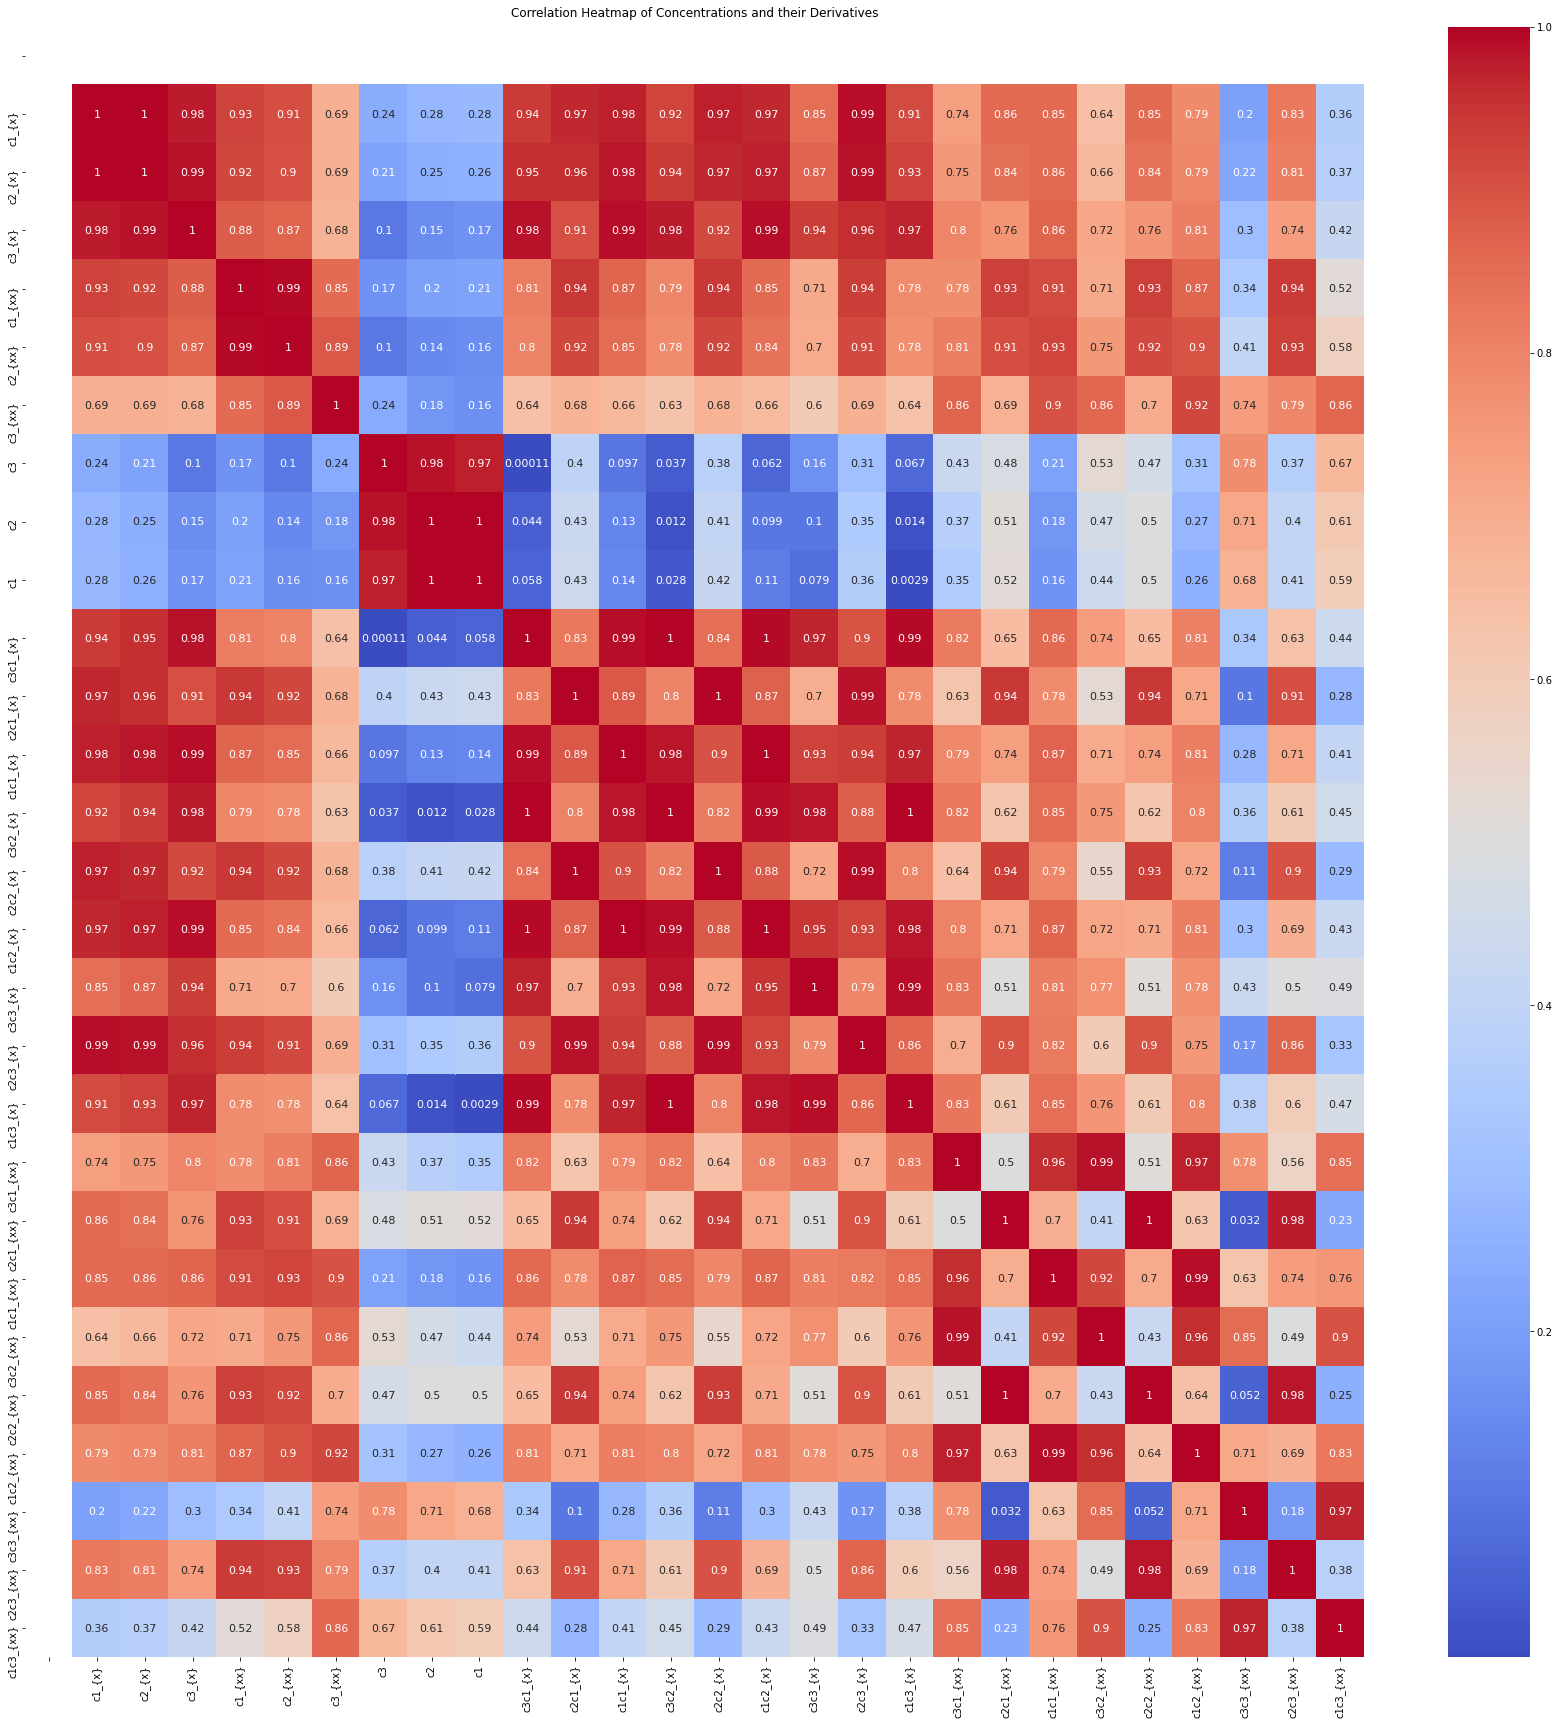

In [57]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X)
corr = np.corrcoef(Xs.T)
plt.figure(figsize=(30, 30))
sns.heatmap(np.abs(corr), annot=True, cmap='coolwarm', xticklabels=desc, yticklabels=desc, annot_kws={"fontsize":11})
plt.title("Correlation Heatmap of Concentrations and their Derivatives", pad=10)
plt.show()

In [58]:
u, s, v = np.linalg.svd(Xs, full_matrices=False)
s

array([8.33670134e+02, 4.66583421e+02, 2.53769488e+02, 9.69025402e+01,
       6.20403687e+01, 4.92945398e+01, 4.36316928e+01, 2.00455295e+01,
       1.11565209e+01, 8.25347699e+00, 5.79190519e+00, 3.26139567e+00,
       2.84969008e+00, 1.51837022e+00, 7.78638919e-01, 5.45138368e-01,
       4.50022214e-01, 3.83000505e-01, 8.47163522e-02, 1.07347539e-02,
       5.61649504e-03, 1.23213387e-03, 4.34592367e-04, 1.82536141e-04,
       6.30370038e-05, 3.60877724e-05, 8.25969162e-07, 5.62387125e-14])

In [59]:
print(Xs.shape[1] - np.linalg.matrix_rank(Xs))

1


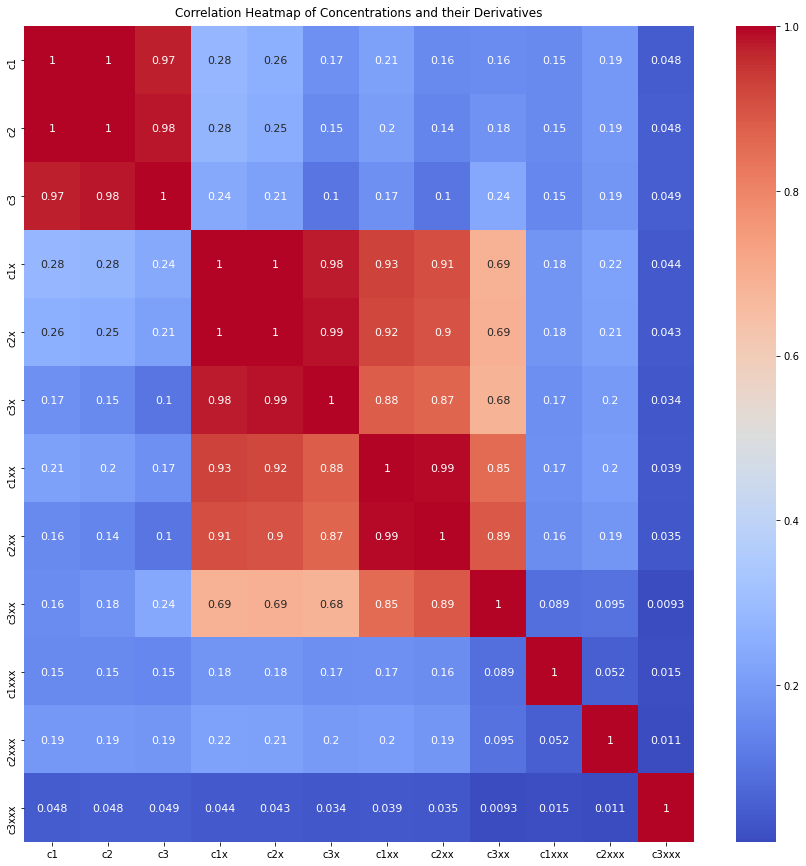

In [60]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(np.hstack([c1r, c2r, c3r, c1x, c2x, c3x, c1xx, c2xx, c3xx, c1xxx, c2xxx, c3xxx]))
descs = ['c1', 'c2', 'c3', 'c1x', 'c2x', 'c3x', 'c1xx', 'c2xx', 'c3xx', 'c1xxx', 'c2xxx', 'c3xxx']
corr = np.corrcoef(Xs.T)
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(corr), annot=True, cmap='coolwarm', xticklabels=descs, yticklabels=descs, annot_kws={"fontsize":11})
plt.title("Correlation Heatmap of Concentrations and their Derivatives", pad=10)
plt.show()

In [61]:
print(np.mean([c1xxx + c2xxx + c3xxx]))

0.03643890699166852


# Can Linear Reg get the right coefficients?

In [74]:
print(X.shape, y.shape)

sols = fit_path(X, y, lambda_2 = 3e-2, max_nonzeros = 5, intercept=False)

(36864, 28) (36864,)
Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  4
Iteration: 4. Number of non-zeros:  12


In [73]:
return_pde(sols[2]["B"], desc)

'u_t = (9.037091) + (2.065475)c2 + (0.991310)c3c1_{xx} + (-0.741153)c3c2_{xx}'

In [263]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

Xl0 = np.hstack([c2r, c3r, c3x])
y = c1t
model = LinearRegression(fit_intercept=False).fit(Xl0, y)
print(model.coef_, model.intercept_) 
ypredl0 = model.predict(Xl0)
print(r2_score(ypredl0, y), mse(ypredl0, y, squared=False)/np.median(y))

[[ -2.29754374   4.58331494   5.41420174 -12.02381156]] 0.0
0.9511462833395088 8.888815852194861


In [ ]:
Xlr = np.hstack([c1r, c2r, c3r, c1x, c1xx])
y = c1t
model = LinearRegression(fit_intercept=False).fit(Xlr, y)
print(model.coef_, model.intercept_) 
ypred = model.predict(Xlr)
print(r2_score(ypred, y), mse(ypred, y, squared=False)/np.median(y))

In [259]:
import statsmodels.api as sm
alpha = 0.05
l0 = sm.OLS(y, Xl0).fit()
l0.conf_int(alpha)

array([[ -2.54636117,  -2.0487263 ],
       [  4.49706235,   4.66956753],
       [  4.43932085,   6.38908263],
       [-12.2099333 , -11.83768983]])

In [124]:
import statsmodels.api as sm
alpha = 0.05
lr = sm.OLS(y, Xlr).fit()
lr.conf_int(alpha)

array([[-1.02758952, -1.02090863],
       [ 5.00330092,  5.00511638],
       [ 0.07895372,  0.10536236],
       [-2.00306286, -2.00043274],
       [ 0.99826772,  1.00013721]])

<AxesSubplot:ylabel='Count'>

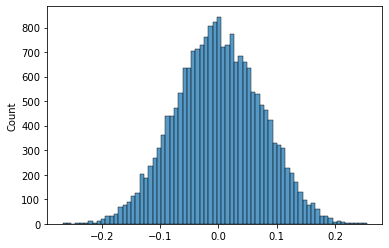

In [260]:
import seaborn as sns
resid = lr.resid 
sns.histplot(resid)

In [261]:
from scipy.stats import kurtosis
np.std(resid)

0.07322424126471756

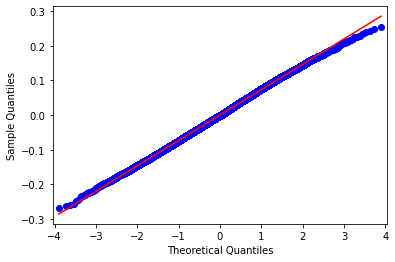

In [262]:
norm = np.random.normal(2, 10, (1000,))
sm.qqplot(resid, line='s')
plt.show()

# Alt. methods?

In [349]:
from sklearn.linear_model import LinearRegression, ElasticNetCV, Lasso
from sklearn.metrics import r2_score
import statsmodels.api as sm

'''
X = np.hstack([c1r, c2r, c3r, c1x, c2x, c3x, c1xx, c2xx, c3xx])
y = c1t.reshape(c1t.shape[0])


model = Lasso(alpha=3e-2, fit_intercept=False).fit(X, y)
print(model.coef_, model.intercept_) 
ypred = model.predict(X)
print(r2_score(ypred, y))

'''
X = np.hstack([c1r, c2r, c3r, c3x, c1xx, c3xx])
y = c1t.reshape(c1t.shape[0])


model = LinearRegression(fit_intercept=False).fit(X, y)
print(model.coef_, model.intercept_) 
ypred = model.predict(X)
print(r2_score(ypred, y))

[-2.42520127  5.18125945  7.26158422 -7.01596281  0.87335523  1.61836625] 0.0
0.9994865723298715


In [24]:
# Perform SVD on the Train Array to find the number of linear relationships between the variables
X = np.array([c1t, c1r, c2r, c3r, c1x, c2x, c3x, c1xx, c2xx, c3xx])
desc = ['c1_{t}', 'c1', 'c2', 'c3', 'c1_{x}', 'c2_{x}', 'c3_{x}', 'c1_{xx}', 'c2_{xx}', 'c3_{xx}']

In [25]:
X = X.reshape((X.shape[0], X.shape[1]))
X.shape

(10, 20164)

In [26]:
Xs = StandardScaler().fit_transform(X)

In [27]:
u, s, v = np.linalg.svd(Xs.T, full_matrices=False)
s

array([4.05209430e+02, 1.74261949e+02, 7.91678547e+01, 2.77286955e+01,
       5.72501118e+00, 2.31248631e+00, 1.78720005e+00, 5.18411471e-01,
       2.73351926e-01, 5.57153566e-14])

In [28]:
v[:][-1]

array([0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777])

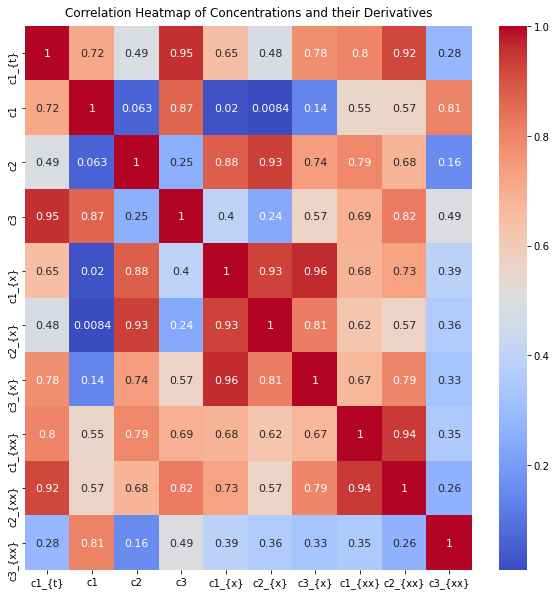

In [29]:
import seaborn as sns
corr = np.abs(np.corrcoef(Xs))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=desc, yticklabels=desc,  annot_kws={"fontsize":11})
plt.title("Correlation Heatmap of Concentrations and their Derivatives", pad=10)
plt.show()